# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [100]:
def get_probabilities(r: np.ndarray):
    unique, counts = np.unique(r, return_counts=True)
    return counts / r.shape[0]

In [101]:
def entropy(r: np.ndarray):
    p = get_probabilities(r)
    return -np.sum(p * np.log(p))

In [102]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
k1 = 1
k2 = 2
r = np.concatenate([np.repeat(k1, 8), np.repeat(k2, 2)])
print(f'Entropy: {entropy(r):.2f}')

Entropy: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [103]:
def gini_criterion(r: np.ndarray):
    p = get_probabilities(r)
    return np.sum(p * (1 - p))

In [104]:
def information_gain(rm: np.ndarray, rl: np.ndarray, rr: np.ndarray, h=gini_criterion):
    q = h(rm) - rl.shape[0] / rm.shape[0] * h(rl) - rr.shape[0] / rm.shape[0] * h(rr)
    return q

In [105]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
rm = r
rl = np.repeat(k1, 8)
rr = np.repeat(k2, 2)

print(f'Information gain: {information_gain(rm, rl, rr):.2f}')

Information gain: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [106]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

print(f"Prediction: {np.mean(leaf)}")

Prediction: 40.6


Предсказания для всех этих объектов будут равными среднему значению целевой переменной в листе, то есть 40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [107]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [108]:
def find_best_split(
        feature_vector: Union[np.ndarray, pd.DataFrame],
        target_vector: Union[np.ndarray, pd.Series],
        task: str = "classification",
        feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    fv = np.unique(feature_vector)
    fv.sort()

    thresholds = fv
    if feature_type == 'real':
        thresholds = (fv[1:] + fv[:-1]) / 2

    h = np.var
    if task == 'classification':
        h = gini_criterion

    def calculate_quality(n):
        if feature_type == 'real':
            rl = target_vector[feature_vector < n]
            rr = target_vector[feature_vector >= n]
        else:
            rl = target_vector[feature_vector == n]
            rr = target_vector[feature_vector != n]
        return information_gain(target_vector, rl, rr, h)

    cq = np.vectorize(calculate_quality)
    ginis = cq(thresholds)
    threshold_best = thresholds[np.argmax(ginis)]
    gini_best = np.max(ginis)
    return thresholds, ginis, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [109]:
from sklearn.datasets import fetch_california_housing

In [110]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [111]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [112]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
thresholds, impurities, threshold_best, gini_best = find_best_split(X['MedInc'], y, task="regression")
print(threshold_best)

5.03515


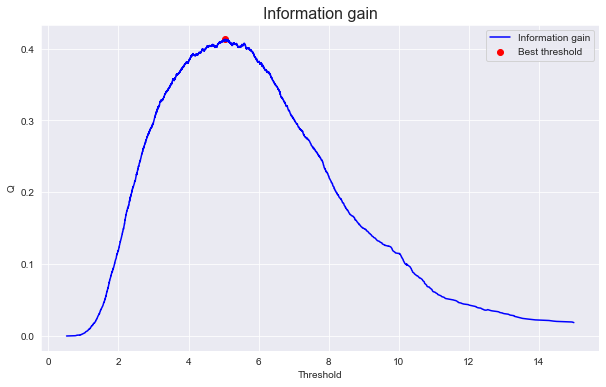

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(thresholds, impurities, 'b-', label="Information gain")
plt.scatter(x=[threshold_best], y=[gini_best], c=["red"], label="Best threshold")
plt.grid(visible=True)
plt.title("Information gain", fontsize=16)
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Q')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [114]:
X.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [115]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
feature_best = 'MedInc'
threshold_best = threshold_best
gini_best = gini_best
for feat in X.columns:
    _, _, threshold, gini = find_best_split(X[feat], y, task="regression")
    if gini > gini_best:
        gini_best = gini
        threshold_best = threshold
        feature_best = feat

print(f"The best predicate is '{feature_best}' < {threshold_best}")
print(f"The best information gain is {gini_best:.4f}")

The best predicate is 'MedInc' < 5.03515
The best information gain is 0.4128


Лучший предикат первой вершины: 'MedInc' < 5.03515
Лучшее значение критерия информативности: 0.4128

Сравним с результатом работы дерева решений из sklearn

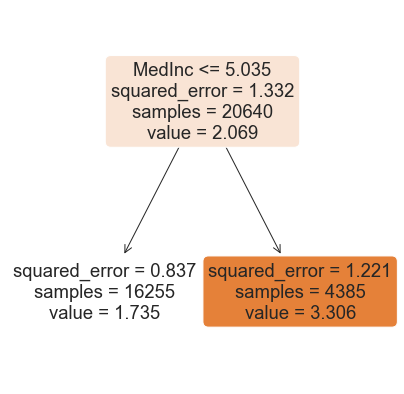

In [116]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
fig = plt.figure(figsize=(7, 7))
dt = DecisionTreeRegressor(max_depth=1, random_state=13)
dt.fit(X, y)
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()

Дерево решений из sklearn выдало такой же результат!

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [117]:
class DecisionTree:

    def __init__(
            self,
            feature_types: Union[List[str], np.ndarray],
            max_depth: int = None,
            min_samples_split: int = None,
            min_samples_leaf: int = None,
            task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        self.feature_importances_ = None

    def _fit_node(
            self,
            sub_X: np.ndarray,
            sub_y: np.ndarray,
            node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature_best] < threshold_best  # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = sub_X[:, feature_best] == threshold_best  # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        self._feature_importances[feature_best] += gini_best
        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        if node["type"] == "terminal":
            return node["class"]

        if "threshold" in node.keys():
            if x[node["feature_split"]] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif "category_split" in node.keys():
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._feature_importances.clear()
        for i in range(len(self._feature_types)):
            self._feature_importances[i] = 0

        self._fit_node(X, y, self._tree)

        fi_np = np.array(list(self._feature_importances.values()))
        self.feature_importances_ = fi_np / np.sum(fi_np)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

Реализованы:
* Метод оценки важности признаков (нормализованная сумма information gain по каждому признаку ~ Gini importance);

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [118]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
data = pd.read_csv('students.csv')
data.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [119]:
data = data.drop('Unnamed: 0', axis=1)
X = data.drop('UNS', axis=1)
y = data["UNS"]
X.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


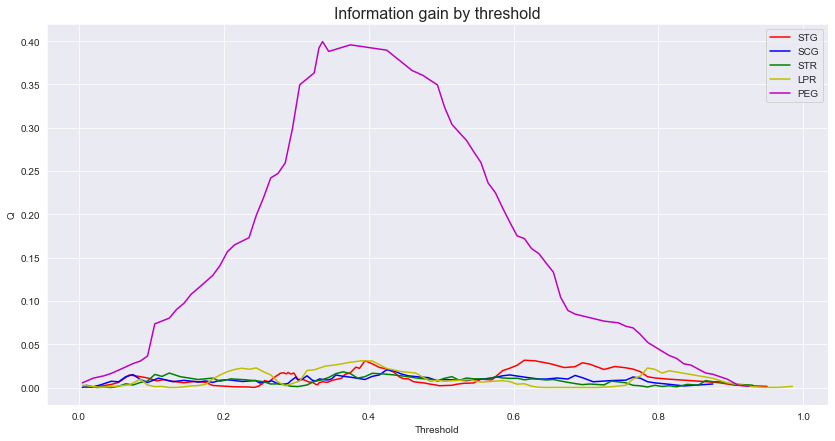

In [120]:
fig = plt.figure(figsize=(14, 7))
colors = ['r-', 'b-', 'g-', 'y-', 'm-']
plt.grid(visible=True)

for i, feature in enumerate(X.columns):
    thresholds, impurities, _, _ = find_best_split(X[feature], y, task="classification")
    plt.plot(thresholds, impurities, colors[i], label=feature)

plt.title("Information gain by threshold", fontsize=16)
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Q')

plt.show()

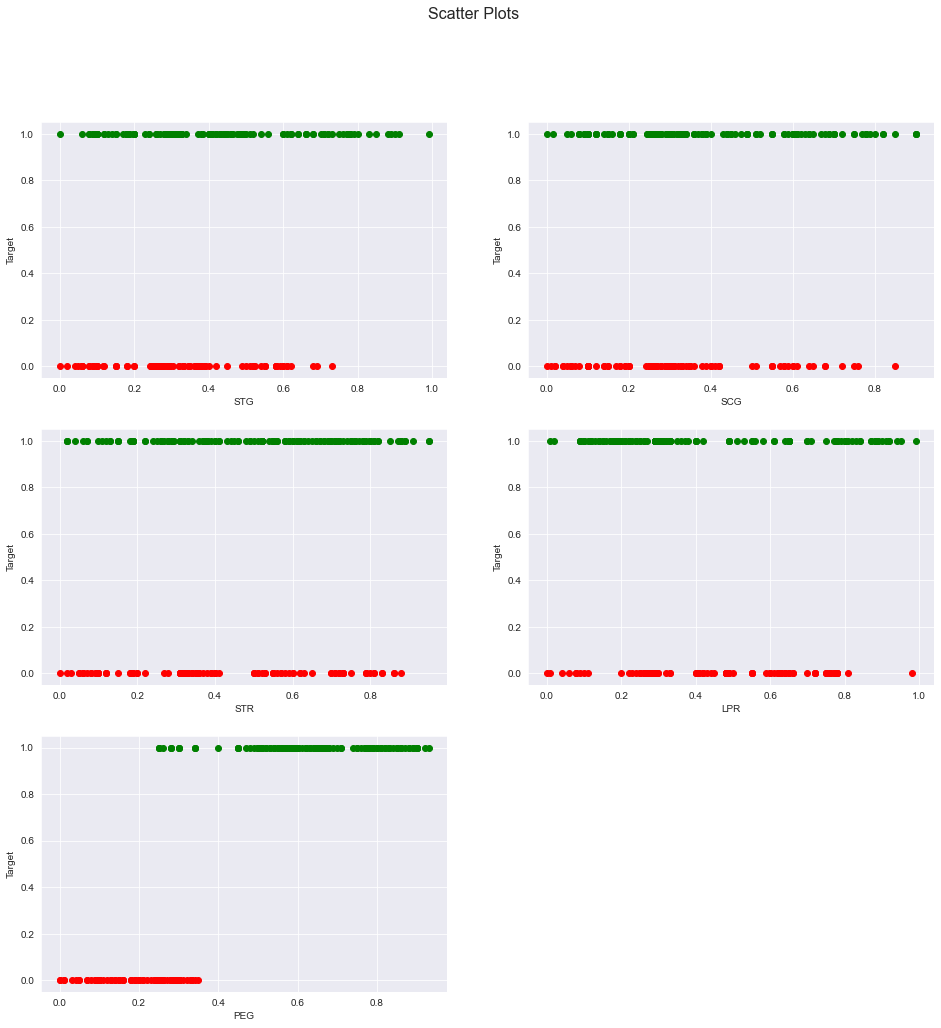

In [121]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Scatter Plots", fontsize=16, )

gs = gridspec.GridSpec(3, 2)
color_by_val = {0: 'red', 1: 'green'}
for i, feature in enumerate(X.columns):
    plt.subplot(gs[i // 2, i % 2])
    plt.xlabel(feature)
    plt.ylabel("Target")

    # plt.scatter(x=X[feature], y=y)
    # Построим диаграмму рассеяния для положительных и отрицательных кейсов
    for value, color in color_by_val.items():
        plt.scatter(x=X[y == value][feature], y=y[y == value], c=[color])

plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

### Ответ
1. Исходя из кривых, наиболее подходящим признаком для деления на два поддерева является PEG, так как разделение по этому признаку позволяет достичь наибольшего критерия информативности;
2. Этот результат полностью согласуется с результатами визуальной оценки диаграмм рассеяния: на диаграмме рассеяния для признака PEG положительные и отрицательные кейсы делятся практически идеально (сначала идут все отрицательные кейсы, а после все положительные), тогда как на остальных диаграммах отрицательные и положительные кейсы перемешаны;
3. Для хороших признаков кривые порогов имеют вид 'горы' (сначала возрастают до определенного значения, достигают в нем максимума, а затем убывают);
4. Для признаков, разбиение по которым практически невозможно, кривые представляют собой ломаные, колеблющиеся около нулевого значения.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [122]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data")
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [123]:
data.shape

(8123, 23)

In [124]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [125]:
le = LabelEncoder()
data_encoded = data
for x in data_encoded.columns:
    if data_encoded[x].dtype == 'object':
        data_encoded[x] = LabelEncoder().fit_transform(data_encoded[x])

In [126]:
data_encoded.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [127]:
X = data_encoded.drop('p', axis=1)
y = data_encoded.p

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [129]:
dt = DecisionTree(feature_types=np.repeat('categorical', len(X.columns)))

In [130]:
dt.fit(X_train.values, y_train.values)

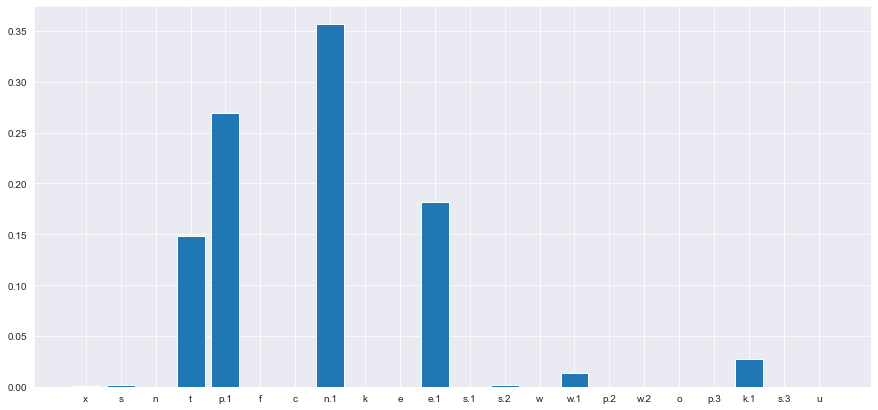

In [131]:
# Проверка реализации подсчета значимости признаков
plt.figure(figsize = (15, 7))
plt.bar(X_train.columns, dt.feature_importances_)
plt.show()

In [132]:
accuracy = accuracy_score(y_test.values, dt.predict(X_test.values))

In [133]:
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


Мы получили: Accuracy = 1

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [135]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [136]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

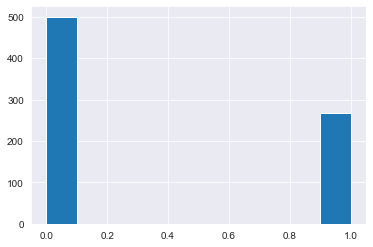

In [137]:
data['Outcome'].hist()
plt.show()

In [138]:
data['Outcome']

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [139]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
y = data['Outcome']
X = data.drop('Outcome', axis=1)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [140]:
import itertools
from sklearn.metrics import f1_score

Подбираем гиперпараметры `max_depth` и `min_samples_leaf`

In [141]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
max_depths = range(2, 30)
min_samples_leaf_array = range(2, 30)
min_samples_leaf_best = 0
max_depth_best = 0
f1_best = None

for depth, min_samples_count in itertools.product(max_depths, min_samples_leaf_array):
    dt_cls = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_count, random_state=42)
    dt_cls.fit(X_train, y_train)
    f1_cur = f1_score(y_val, dt_cls.predict(X_val))
    if f1_best is None or f1_cur > f1_best:
        f1_best = f1_cur
        max_depth_best = depth
        min_samples_leaf_best = min_samples_count

Выводим лучшее значение `F1-меры` и соответствующие ему значения гиперпараметров.

In [142]:
print(f"The best F1-score is {f1_best:.4f}")
print(f"The best F1-score is achieved with max_depth = {max_depth_best} and min_samples_leaf = {min_samples_leaf_best}")

The best F1-score is 0.7143
The best F1-score is achieved with max_depth = 7 and min_samples_leaf = 7


In [143]:
dt_cls = DecisionTreeClassifier(max_depth=max_depth_best, min_samples_leaf=min_samples_leaf_best, random_state=42)
dt_cls.fit(X_train_full, y_train_full)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=7, random_state=42)

Обучаем модель с подобранными гиперпараметрами

In [144]:
accuracy = accuracy_score(y_test, dt_cls.predict(X_test))
precision = precision_score(y_test, dt_cls.predict(X_test))
recall = recall_score(y_test, dt_cls.predict(X_test))
auc_roc = roc_auc_score(y_test, dt_cls.predict(X_test))

In [145]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.6970
Precision: 0.5556
Recall: 0.6250
AUC-ROC: 0.6800


Значения метрик качества:
* Accuracy: 0.6970
* Precision: 0.5556
* Recall: 0.6250
* AUC-ROC: 0.6800

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [146]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
bagging_cls = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth_best,
                                                                      min_samples_leaf=min_samples_leaf_best, random_state=42),
                                n_estimators=50, random_state=42)
bagging_cls.fit(X_train_full, y_train_full)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7,
                                                        min_samples_leaf=7,
                                                        random_state=42),
                  n_estimators=50, random_state=42)

In [147]:
f = f1_score(y_test, bagging_cls.predict(X_test))
accuracy = accuracy_score(y_test, bagging_cls.predict(X_test))
precision = precision_score(y_test, bagging_cls.predict(X_test))
recall = recall_score(y_test, bagging_cls.predict(X_test))
auc_roc = roc_auc_score(y_test, bagging_cls.predict(X_test))

In [148]:
print(f"F1-score: {f:.4f}")

F1-score: 0.6543


In [149]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.7576
Precision: 0.6463
Recall: 0.6625
AUC-ROC: 0.7352


Значения метрик качества:
* Accuracy: 0.7576
* Precision: 0.6463
* Recall: 0.6625
* AUC-ROC: 0.7352

Сравнение бэггинга с деревом решений:
* Accuracy выросла на 0.06
* Precision вырос на 0.09
* Recall вырос на 0.0375
* AUC-ROC вырос на 0.055

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [150]:
from sklearn.model_selection import cross_val_score

Подбираем гиперпараметры `max_depth` и `min_samples_leaf`

In [151]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
max_depths = range(2, 20)
min_samples_leaf_array = range(2, 20)
min_samples_leaf_best = 0
max_depth_best = 0
f1_best = None

for depth, min_samples_count in itertools.product(max_depths, min_samples_leaf_array):
    rf_cls = RandomForestClassifier(n_estimators=50, max_depth=depth, min_samples_leaf=min_samples_count, random_state=42)
    scores = cross_val_score(rf_cls, X_train_full, y_train_full, cv=5, scoring='f1_macro')
    f1_cur = scores.mean()
    if f1_best is None or f1_cur > f1_best:
        f1_best = f1_cur
        max_depth_best = depth
        min_samples_leaf_best = min_samples_count

Выводим лучшее значение `F1-меры` и соответствующие ему значения гиперпараметров.

In [152]:
print(f"The best F1-score is {f1_best:.4f}")
print(f"The best F1-score is achieved with max_depth = {max_depth_best} and min_samples_leaf = {min_samples_leaf_best}")

The best F1-score is 0.7421
The best F1-score is achieved with max_depth = 12 and min_samples_leaf = 5


Обучаем модель с подобранными гиперпараметрами

In [153]:
rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth_best, min_samples_leaf=min_samples_leaf_best, random_state=42)
rf.fit(X_train_full, y_train_full)

RandomForestClassifier(max_depth=12, min_samples_leaf=5, n_estimators=50,
                       random_state=42)

In [154]:
accuracy = accuracy_score(y_test, rf.predict(X_test))
precision = precision_score(y_test, rf.predict(X_test))
recall = recall_score(y_test, rf.predict(X_test))
auc_roc = roc_auc_score(y_test, rf.predict(X_test))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.7489
Precision: 0.6279
Recall: 0.6750
AUC-ROC: 0.7315


Значения метрик качества:
* Accuracy: 0.7489
* Precision: 0.6279
* Recall: 0.6750
* AUC-ROC: 0.7315

Сравнение случайного леса с бэггингом:
* Accuracy уменьшилась на 0.009
* Precision уменьшился на 0.018
* Recall вырос на 0.013
* AUC-ROC уменьшился на 0.004

#### Выводы
* Бэггинг показал лучший результат по большинству метрик, включая accuracy, precision и AUC-ROC;
* При этом случайный лес показал более высокие значения F1-меры и recall;
* Так как мы хотим оценить модель независимо от порога, то ориентируемся по AUC-ROC, а значит лучшей моделью является бэггинг

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [155]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
n_trees = 200
roc_auc_scores = []

for i in range(1, n_trees):
    rf = RandomForestClassifier(n_estimators = i, random_state = 42)
    rf.fit(X_train_full, y_train_full)
    roc_auc_scores.append(roc_auc_score(y_test, rf.predict(X_test)))

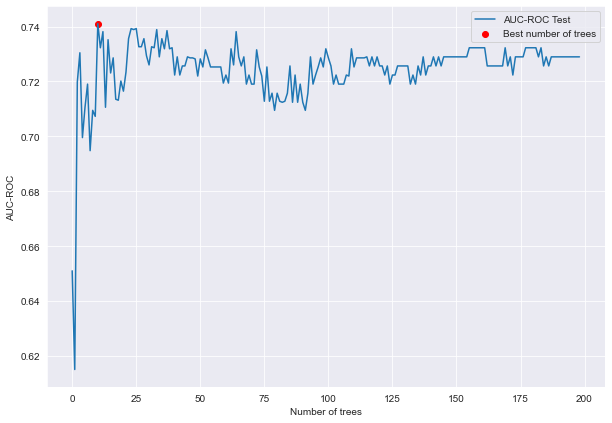

In [156]:
plt.figure(figsize = (10, 7))
plt.plot(roc_auc_scores, label = 'AUC-ROC Test')

roc_auc_np = np.array(roc_auc_scores)
plt.scatter(x=[np.argmax(roc_auc_np)], y=[np.max(roc_auc_np)], c=["red"], label="Best number of trees")

plt.ylabel('AUC-ROC')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

#### Выводы:
* График подтверждает, что случайный лес не переобучается при росте числа деревьев;
* Качество модели при росте числа деревьев сначала быстро увеличивается, достигая максимума уже при 10 деревьях, а затем (при количестве деревьев около 25 выходит на плато и колеблется около максимума;
* Оптимальным число деревьев - 10, так как при этом количестве деревьев AUC-ROC достигает максимума.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [157]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(———
# —
rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth_best, min_samples_leaf=min_samples_leaf_best)
rf.fit(X_train_full, y_train_full)

RandomForestClassifier(max_depth=12, min_samples_leaf=5, n_estimators=50)

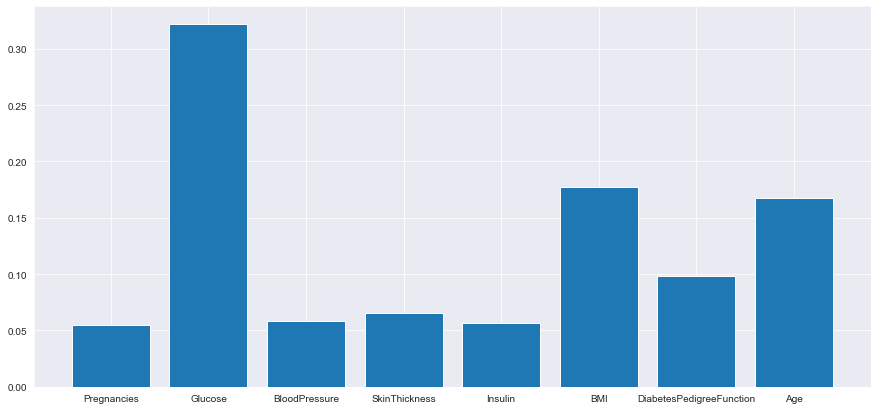

In [158]:
plt.figure(figsize = (15, 7))
plt.bar(X_train_full.columns, rf.feature_importances_)
plt.show()

#### Вывод
1. Самым важным для определения диабета оказался уровень глюкозы;
2. BMI на втором месте по значимости;
3. На третьем месте - возраст.